In [1]:
import comet_ml

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [3]:
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt

In [4]:
import os.path as osp
import pickle

In [5]:
# from beetl.task_datasets import BeetlSleepTutorial, BeetlSleepSource, BeetlSleepLeaderboard, BeetlMILeaderboard
# ds = BeetlSleepSource()
# path = ds.download()
# print(path)
# X, y, info = ds.get_data()

In [6]:
# BeetlSleepLeaderboard().download()

In [7]:
SEED=997
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

In [125]:
hyper_params = {
    "lr": lr,
    "weight_decay": 1e-6,
    "scheduler_patience": 10,
    'batch_size': 256,
    'dropout_conv': 0.1,
    'dropout_fc': 0.2
}

In [8]:
def plot_label_distribution(y):
    (unique, counts) = np.unique(np.asarray(y), return_counts=True)
    frequencies = np.asarray((unique, counts)).T
    plt.bar(unique, counts)
    plt.show()

In [9]:
# for i in range(39):
#     _, y, _ = dataset.get_data(subjects=[i])
#     plot_label_distribution(y)

# Load train, validation and test data

## Train data and validation data

Train data and validation data are from the same set of data and are assumed to be from one distribution.

In [10]:
from beetl.task_datasets import BeetlSleepSource
dataset = BeetlSleepSource()
from sklearn.model_selection import train_test_split

# X_train, y_train, info = dataset.get_data(subjects=range(0, 35))
# X_test, y_test, _ = dataset.get_data(subjects=range(35, 39))

X, y, _ = dataset.get_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

(72436, 2, 3000)
[[    0 19257]
 [    1  6470]
 [    2 28763]
 [    3  4213]
 [    4  2400]
 [    5 11333]]


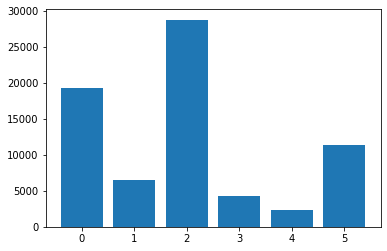

In [11]:
print(X_train.shape)
(unique, counts) = np.unique(np.asarray(y_train), return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
plt.bar(unique, counts)
plt.show()

(18109, 2, 3000)
[[   0 4786]
 [   1 1471]
 [   2 7220]
 [   3 1034]
 [   4  657]
 [   5 2941]]


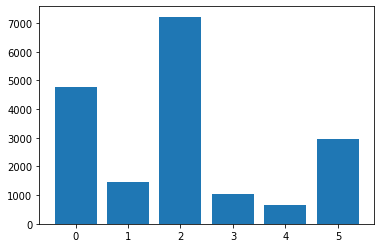

In [12]:
print(X_test.shape)
(unique, counts) = np.unique(np.asarray(y_test), return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
plt.bar(unique, counts)
plt.show()

From the above 2 histograms, we can see that they have similar labels' distribution.

## Test data

Test data is from a different set of subjects and have a different distribution.

In [13]:
from beetl.task_datasets import BeetlSleepLeaderboard
X_sleep_target, y_sleep_target, _, _ = BeetlSleepLeaderboard().get_data(subjects=range(0, 6))

(15442, 2, 3000)


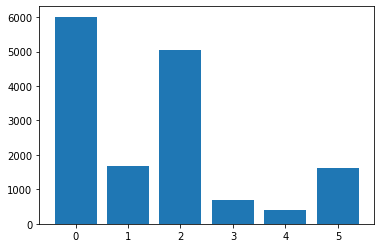

In [14]:
print(X_sleep_target.shape)
(unique, counts) = np.unique(y_sleep_target, return_counts=True)
plt.bar(unique, counts)
plt.show()

# Dataloaders

In [15]:
from torch.utils.data import DataLoader, Dataset

class EEG_data(Dataset):
    def __init__(self, train_data, train_label, mode='train'):
        mean = np.mean(train_data, axis=2, keepdims=True)
        std = np.std(train_data, axis=2, keepdims=True)
        self.X = (train_data - mean) / std
        self.X = np.transpose(self.X, (0, 2, 1))
        self.X = np.expand_dims(self.X, axis=1)
        self.y = train_label
        self.mode = mode
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        shape = self.X[0].shape
        noise = np.random.normal(0, 0.04, 6000).reshape(shape)
        if self.y is not None:
            return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)
        else:
            return torch.tensor(self.X[idx], dtype=torch.float32)

In [16]:
X_train.shape

(72436, 2, 3000)

In [17]:
train_dataset = EEG_data(X_train, y_train)
test_dataset = EEG_data(X_test, y_test, mode='test')
print(train_dataset.X.shape) # should be length, 1, 3000, 2

(72436, 1, 3000, 2)


(array([  24.,   53.,  235.,  933., 1073.,  494.,  151.,   26.,    5.,
           6.]),
 array([-3.75888466, -2.87629739, -1.99371013, -1.11112286, -0.2285356 ,
         0.65405166,  1.53663893,  2.41922619,  3.30181346,  4.18440072,
         5.06698798]),
 <BarContainer object of 10 artists>)

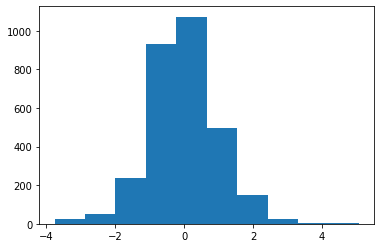

In [18]:
plt.hist(train_dataset.X[0][0][:, 0])

In [19]:
from pytorch_metric_learning import samplers

In [20]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, sampler=samplers.MPerClassSampler(labels=y_train, m=BATCH_SIZE // 6, length_before_new_iter=24000), batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

In [21]:
transfer_dataset = EEG_data(X_sleep_target, y_sleep_target)
transfer_loader = torch.utils.data.DataLoader(dataset=transfer_dataset, batch_size=128)

# LSTM NET

In [22]:
import torch.nn as nn
import torch.nn.functional as F
    
class LSTMNet(nn.Module):
    def __init__(self, n_classes):
        super(LSTMNet, self).__init__()
        self.drop1 = nn.Dropout(0.5)
        self.drop_ch = nn.Dropout2d(0.1)
        self.fc = nn.Linear(128, n_classes)
        self.n_classes = n_classes

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=[10, 2], stride=1)
        self.bn1 = nn.BatchNorm1d(16)
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=10, stride=1)
        self.bn2 = nn.BatchNorm1d(32)
        
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=10, stride=1)
        self.bn3 = nn.BatchNorm1d(64)
        
        self.pool = nn.MaxPool1d(4)

        self.lstm = nn.LSTM(input_size=64, hidden_size=128, batch_first=True)

        torch.nn.init.kaiming_normal_(self.conv1.weight)
        torch.nn.init.kaiming_normal_(self.conv2.weight)
        torch.nn.init.kaiming_normal_(self.conv3.weight)
        torch.nn.init.kaiming_normal_(self.fc.weight)

    def forward(self, x):
        output = self.bn1(self.pool(F.relu(self.conv1(x)).reshape(x.shape[0], self.conv1.out_channels, -1)))
        output = torch.squeeze(self.drop_ch(torch.unsqueeze(output, 3)))
        
        output = self.bn2(self.pool(F.relu(self.conv2(output))))
        output = torch.squeeze(self.drop_ch(torch.unsqueeze(output, 3)))
        
        output = self.bn3(self.pool(F.relu(self.conv3(output))))
        output = torch.squeeze(self.drop_ch(torch.unsqueeze(output, 3)))
        # output's shape is batch, 64, 37
        
        outputs, _ = self.lstm(torch.transpose(output, 2, 1)) # batch, seq_len, hidden_size
#         _, (outputs, _) = self.lstm(torch.transpose(output, 2, 1)) # batch, seq_len, hidden_size
        output = torch.mean(outputs, 1) # batch, hidden_size
#         output = torch.squeeze(outputs)
        output = F.relu(self.fc(self.drop1(output)))
        return output


In [23]:
import torch.nn as nn
import torch.nn.functional as F
    
class WvNet(nn.Module):
    def __init__(self, n_classes):
        super(WvNet, self).__init__()
        self.drop_fc = nn.Dropout(0.5)
        self.drop_conv = nn.Dropout2d(0.1)
        self.fc = nn.Linear(128, n_classes)
        self.n_classes = n_classes

        self.conv_5 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=[80, 2], stride=1)
        self.bn_5 = nn.BatchNorm2d(8)
        self.pool_5 = nn.AdaptiveMaxPool2d((60, 1))
        
        self.conv_10 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=[160, 2], stride=1)
        self.bn_10 = nn.BatchNorm2d(8)
        self.pool_10 = nn.AdaptiveMaxPool2d((60, 1))
        
        self.conv_20 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=[20, 2], stride=1)
        self.bn_20 = nn.BatchNorm2d(8)
        self.pool_20 = nn.AdaptiveMaxPool2d((60, 1))
        
        self.conv_40 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=[40, 2], stride=1)
        self.bn_40 = nn.BatchNorm2d(8)
        self.pool_40 = nn.AdaptiveMaxPool2d((60, 1))
        
        self.conv_gr1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=[4, 5], stride=1)
        self.bn_gr1 = nn.BatchNorm2d(16)
        
        self.conv_gr2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=[5, 5], stride=1)
        self.bn_gr2 = nn.BatchNorm2d(64)

        self.lstm = nn.LSTM(input_size=self.conv_gr2.out_channels, hidden_size=128, batch_first=True)

        torch.nn.init.kaiming_normal_(self.conv_5.weight)
        torch.nn.init.kaiming_normal_(self.conv_10.weight)
        torch.nn.init.kaiming_normal_(self.conv_20.weight)
        torch.nn.init.kaiming_normal_(self.conv_40.weight)
        torch.nn.init.kaiming_normal_(self.fc.weight)

    def forward(self, x):
        output_5 = self.bn_5(self.pool_5(F.relu(self.conv_5(x))))
        output_5 = torch.squeeze(self.drop_conv(output_5))
        
        output_10 = self.bn_10(self.pool_10(F.relu(self.conv_10(x))))
        output_10 = torch.squeeze(self.drop_conv(output_10))
        
        output_20 = self.bn_20(self.pool_20(F.relu(self.conv_20(x))))
        output_20 = torch.squeeze(self.drop_conv(output_20))
        
        output_40 = self.bn_40(self.pool_40(F.relu(self.conv_40(x))))
        output_40 = torch.squeeze(self.drop_conv(output_40))
        
        output = torch.stack((output_5, output_10, output_20, output_40), dim=1)
        # output's shape is batch, 4, 8, 60
        
        output = self.bn_gr1(F.relu(self.conv_gr1(output)))
        output = self.drop_conv(output) # .view(output.shape[0], -1, output.shape[-1])
        # batch, 16, 5, 55
        
        output = self.bn_gr2(F.relu(self.conv_gr2(output)))
        output = torch.squeeze(self.drop_conv(output))
        
#         _, (outputs, _) = self.lstm(torch.transpose(output, 2, 1)) # batch, seq_len, hidden_size
#         output = torch.squeeze(outputs)

        outputs, _ = self.lstm(torch.transpose(output, 2, 1)) # batch, seq_len, hidden_size
        output = torch.mean(outputs, 1) # batch, hidden_size

        output = F.relu(self.fc(self.drop_fc(output)))
        return output


In [24]:
import torch.nn as nn
import torch.nn.functional as F
    
class WvConvNet(nn.Module):
    def __init__(self, n_classes):
        super(WvConvNet, self).__init__()
        self.drop_fc = nn.Dropout(0.2)
        self.drop_conv = nn.Dropout2d(0.1)
        self.n_classes = n_classes
        self.conv_f_size = 8
        
        self.conv_fs = nn.ModuleList()
        self.bn_fs = nn.ModuleList()
        self.pool_fs = nn.ModuleList()
        for i in range(8):
            self.conv_fs.append(nn.Conv2d(in_channels=1, out_channels=self.conv_f_size, kernel_size=[5, 2], stride=1, dilation=(2*(i+1), 1)))
            self.bn_fs.append(nn.BatchNorm2d(self.conv_f_size))
            self.pool_fs.append(nn.AdaptiveAvgPool2d((32, 1)))

        self.pool_conv_2d = nn.AvgPool2d((2, 2))
        self.conv_gr1 = nn.Conv2d(in_channels=len(self.conv_fs), out_channels=32, kernel_size=[3, 7], stride=1, padding=(1, 3), groups=2)
        self.bn_gr1 = nn.BatchNorm2d(self.conv_gr1.out_channels)
        
        self.conv_gr2 = nn.Conv2d(in_channels=self.conv_gr1.out_channels, out_channels=32, kernel_size=[3, 7], stride=1, padding=(1, 3), groups=2)
        self.bn_gr2 = nn.BatchNorm2d(self.conv_gr2.out_channels)
        
        self.conv_gr3 = nn.Conv2d(in_channels=self.conv_gr2.out_channels, out_channels=64, kernel_size=[4, 16], stride=1, groups=2)
        self.bn_gr3 = nn.BatchNorm2d(self.conv_gr3.out_channels)
        
        self.fc = nn.Linear(self.conv_gr3.out_channels, n_classes)
    
        for conv in self.conv_fs:
            torch.nn.init.kaiming_normal_(conv.weight)
        torch.nn.init.kaiming_normal_(self.conv_gr1.weight)
        torch.nn.init.kaiming_normal_(self.conv_gr2.weight)
        torch.nn.init.kaiming_normal_(self.conv_gr3.weight)
        torch.nn.init.kaiming_normal_(self.fc.weight)

    def forward(self, x):
        outputs = []
        for i in range(len(self.conv_fs)):
            output = F.relu(self.conv_fs[i](x))
            output = self.bn_fs[i](self.pool_fs[i](output))
#             output = self.drop_conv(output)
            output = torch.squeeze(output)
            outputs.append(output)
        
        output = torch.stack((outputs), dim=1)
#         output = self.drop_conv(output)
        
        output = self.bn_gr1(self.pool_conv_2d(F.relu(self.conv_gr1(output))))
#         output = self.drop_conv(output)
        
#         output = self.bn_gr2(self.pool_conv_2d(F.relu(self.conv_gr2(output))))
#         output = self.drop_conv(output)
        
        output = self.bn_gr3(F.relu(self.conv_gr3(output)))
#         output = self.drop_conv(output)
        output = torch.squeeze(output)

        output = F.relu(self.fc(self.drop_fc(output)))
        return output
    

In [25]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [28]:
from tensorboardX import SummaryWriter

comet_config = {
    "api_key": "",
    "project_name": "sleep-eeg",
    "workspace": "peara",
    "disabled": False
}

def display(tab=None):
    experiment = comet_ml.get_global_experiment()
    experiment.display(tab=tab)

writer = SummaryWriter(comet_config=comet_config)

In [29]:
import torch.optim as optim
from torch.optim import lr_scheduler
from pytorch_metric_learning import losses as loss_fn

model = WvConvNet(n_classes=len(frequencies))
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, min_lr=1e-6)
llos = []
train_acc = []
val_accs = []
tf_accs = []
epoch = 0

In [30]:
writer.add_hparams(
    hparam_dict=hyper_params,
    metric_dict={}
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/peara/sleep-eeg/812b2203349d4aa79b41c2a5c8f9a5eb



In [31]:
model

WvConvNet(
  (drop_fc): Dropout(p=0.2, inplace=False)
  (drop_conv): Dropout2d(p=0.1, inplace=False)
  (conv_fs): ModuleList(
    (0): Conv2d(1, 8, kernel_size=[5, 2], stride=(1, 1), dilation=(2, 1))
    (1): Conv2d(1, 8, kernel_size=[5, 2], stride=(1, 1), dilation=(4, 1))
    (2): Conv2d(1, 8, kernel_size=[5, 2], stride=(1, 1), dilation=(6, 1))
    (3): Conv2d(1, 8, kernel_size=[5, 2], stride=(1, 1), dilation=(8, 1))
    (4): Conv2d(1, 8, kernel_size=[5, 2], stride=(1, 1), dilation=(10, 1))
    (5): Conv2d(1, 8, kernel_size=[5, 2], stride=(1, 1), dilation=(12, 1))
    (6): Conv2d(1, 8, kernel_size=[5, 2], stride=(1, 1), dilation=(14, 1))
    (7): Conv2d(1, 8, kernel_size=[5, 2], stride=(1, 1), dilation=(16, 1))
  )
  (bn_fs): ModuleList(
    (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running

In [55]:
from util.preproc import plot_confusion_matrix

def evaluate(model, loader, confusion_matrix=False):
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0
    predicted_labels = []
    for _, (inputs, labels) in enumerate(loader):
        with torch.no_grad():
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            preds = torch.argmax(outputs, axis=1)
            val_total += len(labels)
            val_correct += torch.sum(labels == preds).item()
            predicted_labels.append(preds.cpu().detach().numpy())
           
            val_loss += loss_fn(outputs, labels) * len(labels)
            
    fig = None
    if confusion_matrix:
        predicted_labels = np.concatenate(predicted_labels)
        fig, ax = plot_confusion_matrix(loader.dataset.y, predicted_labels, classes=['0', '1', '2', '3', '4', '5'],
                                      normalize=True, title='Confusion matrix')
    return val_correct / val_total, val_loss / val_total, fig

In [58]:
from tqdm.notebook import tqdm

while epoch < 80:
    epoch += 1
    if optimizer.state_dict()['param_groups'][0]['lr'] < 1e-5 - 1e-8:
        break
    model.train()
    print(f'Epoch: {epoch}, LR: {optimizer.param_groups[0]["lr"]}')
    running_loss = 0.0
    total_loss = 0
    train_total = 0
    train_correct = 0
    with tqdm(train_loader) as pbar:
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            predicted_labels = torch.argmax(outputs, axis=1)
            train_correct += torch.sum(labels == predicted_labels).item()
            train_total += len(predicted_labels)

            # print statistics
            total_loss += loss.item() * len(labels)
            pbar.set_postfix(loss=total_loss / train_total, accuracy=(train_correct / train_total))
    mean_loss = total_loss / train_total
    llos.append(mean_loss)
    
    train_acc.append(train_correct / train_total)
    
    if epoch % 10 == 0:
        val_acc, val_loss, val_fig = evaluate(model, test_loader, confusion_matrix=True)
        writer.add_figure('validation confusion matrix', val_fig, epoch)
    else:
        val_acc, val_loss, _ = evaluate(model, test_loader)
    tf_acc, tf_loss, _ = evaluate(model, transfer_loader)
    
    scheduler.step(mean_loss)
    
    val_accs.append(val_acc)
    tf_accs.append(tf_acc)
    
    writer.add_scalars(
        'data/losses',
        {
            'train_loss': mean_loss,
            'val_loss': val_loss,
            'transfer_loss': tf_loss,
            
        },
        epoch,
    )
    
    writer.add_scalars(
        'data/accuracies',
        {
            'train_acc': train_correct / train_total,
            'val_acc': val_acc,
            'transfer_acc': tf_acc,
            
        },
        epoch,
    )
print('Finished Training')

Epoch: 50, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

[[4246  361   29   21   11  118]
 [ 189  633  303   20    7  319]
 [  98  795 4679  900  155  593]
 [   6    9   93  639  282    5]
 [   0    0    3  174  480    0]
 [ 118  528  168    9    8 2110]]
Normalized confusion matrix
Epoch: 51, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 52, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 53, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 54, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 55, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 56, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 57, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 58, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 59, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 60, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

[[4080  479   55   28   11  133]
 [ 135  659  364   22    5  286]
 [  50  622 4988  965  134  461]
 [   3    1   96  678  254    2]
 [   0    0    3  198  456    0]
 [  69  571  238   17    7 2039]]
Normalized confusion matrix
Epoch: 61, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 62, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 63, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 64, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 65, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 66, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 67, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 68, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 69, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 70, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

[[4265  351   21   16    8  125]
 [ 197  646  242   21    4  361]
 [  91  911 4425  929  137  727]
 [   7    9   91  667  254    6]
 [   0    0    3  214  440    0]
 [ 129  458  120    8    2 2224]]
Normalized confusion matrix
Epoch: 71, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 72, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 73, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 74, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 75, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 76, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 77, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 78, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 79, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 80, LR: 0.0001


  0%|          | 0/188 [00:00<?, ?it/s]

[[4036  490   42   33   10  175]
 [ 121  626  357   28    7  332]
 [  27  601 4984  976  133  499]
 [   3    4   95  694  237    1]
 [   0    0    2  234  421    0]
 [  51  496  233   15    4 2142]]
Normalized confusion matrix
Finished Training


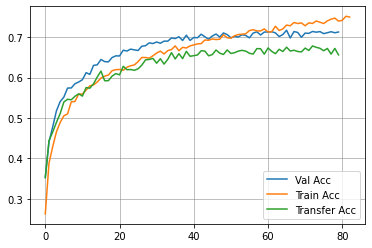

In [124]:
plt.plot(val_accs, label='Val Acc')
plt.plot(train_acc, label='Train Acc')
plt.plot(tf_accs, label='Transfer Acc')
# plt.plot(llos, label='Train loss')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.legend()

In [127]:
f = model.conv_fs[2].weight[6][0][:,0].cpu().detach().numpy()

In [128]:
from scipy import signal
w, h = signal.freqz(f)

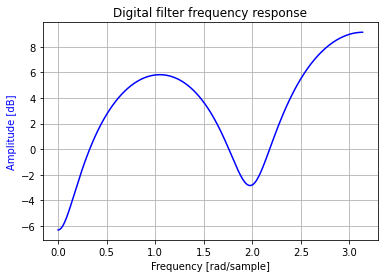

In [129]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.title('Digital filter frequency response')
# ax1 = fig.add_subplot(111)

plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')

# ax2 = ax1.twinx()
# angles = np.unwrap(np.angle(h))
# plt.plot(w, angles, 'g')
# plt.ylabel('Angle (radians)', color='g')
plt.grid()
plt.axis('tight')
plt.show()

In [44]:
torch.save(model, '../models/3-cnn-wv-conv-classification.pth')

In [149]:
writer.close()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/peara/sleep-eeg/812b2203349d4aa79b41c2a5c8f9a5eb
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     data/accuracies_train_acc [80]    : (0.26278195488721806, 0.7514619883040936)
COMET INFO:     data/accuracies_transfer_acc [80] : (0.3521564564175625, 0.6780209817381169)
COMET INFO:     data/accuracies_val_acc [80]      : (0.35363631343530844, 0.7168811088409078)
COMET INFO:     data/losses_train_loss [80]       : (0.6585994383446256, 1.874155538801163)
COMET INFO:     data/losses_transfer_loss [80]    : (0.8277899622917175, 1.6183604001998901)
COMET INFO:     data/losses_val_loss [80]         : (0.7428552508354187, 1.6287425756454468)
COMET INFO:     loss [3122]                       : (0.44916486740112305, 3.856475830078125)
COMET INFO:   

# Submission

In [38]:
from beetl.task_datasets import BeetlSleepLeaderboard
_, _, X_sleep_test, _ = BeetlSleepLeaderboard().get_data(subjects=range(6, 18))

In [39]:
submission_dataset = EEG_data(X_sleep_test, None)
submission_loader = torch.utils.data.DataLoader(dataset=submission_dataset, batch_size=128)

In [40]:
predicted_labels = []
for idx, inputs in enumerate(submission_loader):
    inputs = inputs.to(device)
    with torch.no_grad():
        model.eval()
        outputs = model(inputs)
        pred = np.argmax(outputs.cpu().detach().numpy(), axis=1)
        predicted_labels.extend(pred)
predicted_labels = predicted_labels

In [41]:
print(predicted_labels[:20])
#label from 0 - 5
np.savetxt("answer.txt",predicted_labels,delimiter=',',fmt="%d")

[1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 1, 5, 2, 2, 2, 1]


In [42]:
print(len(predicted_labels))

25748


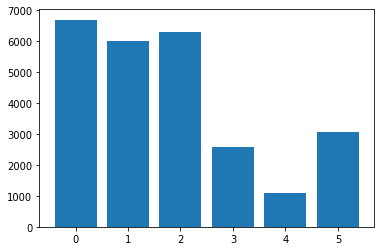

In [43]:
plot_label_distribution(predicted_labels)